# Installing Dependency and basic setup

In [1]:
pip install numpy opencv-python scikit-learn pillow scipy tqdm

In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')

    GDRIVE_PATH = "/content/drive/My Drive/MIR"
    os.makedirs(GDRIVE_PATH, exist_ok=True)
    print(f"Google Drive mounted. Files will be saved to: {GDRIVE_PATH}")

except ImportError:
    print("Not running in Colab. Using local directory for files.")
    GDRIVE_PATH = "."

FEATURES_FILE = os.path.join(GDRIVE_PATH, "hybrid_shape_features.pkl")
PATHS_FILE = os.path.join(GDRIVE_PATH, "hybrid_shape_image_paths.pkl")
MODEL_FILE = os.path.join(GDRIVE_PATH, "hybrid_shape_svm_model.pkl")
SCALER_FILE = os.path.join(GDRIVE_PATH, "hybrid_shape_scaler.pkl")

print(f"--- NOTE: Switched to HYBRID model. Files will be saved to {FEATURES_FILE} ---")

Mounted at /content/drive
Google Drive mounted. Files will be saved to: /content/drive/My Drive/MIR
--- NOTE: Switched to HYBRID model. Files will be saved to /content/drive/My Drive/MIR/hybrid_shape_features.pkl ---


In [26]:
import pickle
import math
import time
from typing import List, Tuple, Dict
import os

import matplotlib.pyplot as plt
from google.colab import files

import numpy as np
import cv2
from PIL import Image
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy import ndimage
try:
    from tqdm import tqdm
except:
    tqdm = lambda x: x

# ----------------------------
# Configuration / Hyperparams
# ----------------------------
IMG_SIZE = (256, 256)
HIST_BINS = 64
TOP_N = 10

In [4]:
def list_images_in_folder(folder: str) -> List[str]:

    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    images = []

    print(f"--- [DEBUG] Starting search in folder: {folder} ---")
    if not os.path.isdir(folder):
        print(f"--- [DEBUG] ERROR: The folder does not exist or is not a directory!")
        return []

    for root, dirs, files in os.walk(folder):

        print(f"--- [DEBUG] Checking in: {root} | Found {len(dirs)} subfolders and {len(files)} files.")

        for f in files:
            if f.lower().endswith(exts):
                images.append(os.path.join(root, f))

    print(f"--- [DEBUG] Search complete. Total images found: {len(images)} ---")
    images.sort()
    return images

def imread_rgb(path: str, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise IOError(f"Cannot read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size is not None:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

# color feature extraction

In [5]:
def color_moments_rgb_hsv(img_rgb: np.ndarray) -> np.ndarray:

    feats = []
    # RGB channels
    for ch in range(3):
        c = img_rgb[:, :, ch].astype(np.float32).flatten()
        feats.append(np.mean(c))
        feats.append(np.std(c))
        try:
            feats.append(skew(c))
        except Exception:
            feats.append(0.0)
    # HSV channels
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    for ch in range(3):
        c = img_hsv[:, :, ch].astype(np.float32).flatten()
        feats.append(np.mean(c))
        feats.append(np.std(c))
        try:
            feats.append(skew(c))
        except Exception:
            feats.append(0.0)
    return np.array(feats, dtype=np.float32)

def color_histograms(img_rgb: np.ndarray, bins=HIST_BINS) -> np.ndarray:

    hs = []
    for ch in range(3):
        h, _ = np.histogram(img_rgb[:, :, ch].flatten(), bins=bins, range=(0, 256))
        if h.sum() != 0:
            h = h.astype(np.float32) / h.sum()
        hs.append(h)

    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    for ch in range(3):
        h, _ = np.histogram(img_hsv[:, :, ch].flatten(), bins=bins, range=(0, 256))
        if h.sum() != 0:
            h = h.astype(np.float32) / h.sum()
        hs.append(h)
    return np.concatenate(hs).astype(np.float32)

def ranklet_like_features(img_rgb: np.ndarray) -> np.ndarray:

    feats = []
    for ch in range(3):
        channel = img_rgb[:, :, ch].astype(np.uint8)
        med = cv2.medianBlur(channel, 3)
        arr = med.flatten().astype(np.float32)
        feats.append(np.mean(arr))
        feats.append(np.std(arr))
        try:
            feats.append(skew(arr))
        except Exception:
            feats.append(0.0)
    return np.array(feats, dtype=np.float32)

# Texture Feature Extraction

In [6]:

!pip install --upgrade scikit-image
print("--- scikit-image install/upgrade complete ---")

from skimage.feature import graycomatrix, graycoprops
import numpy as np
import cv2

print("--- Imports successful (graycomatrix, graycoprops) ---")


# Define GLCM properties
GLCM_DISTANCES = [1]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0, 45, 90, 135 degrees
GLCM_LEVELS = 8

def hgglcm_features(img_rgb: np.ndarray) -> np.ndarray:

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    img_quantized = (img_gray / (256.0 / GLCM_LEVELS)).astype(np.uint8)

    glcm_matrix = graycomatrix(img_quantized,
                               distances=GLCM_DISTANCES,
                               angles=GLCM_ANGLES,
                               levels=GLCM_LEVELS,
                               symmetric=True,
                               normed=True)

    feats = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in properties:

        prop_values = graycoprops(glcm_matrix, prop)

        feats.append(np.mean(prop_values))

    return np.array(feats, dtype=np.float32)

print("--- hgglcm_features() function defined successfully ---")

--- scikit-image install/upgrade complete ---
--- Imports successful (graycomatrix, graycoprops) ---
--- hgglcm_features() function defined successfully ---


# Shape Feature Extraction

In [7]:
def shape_hu_moments_features(img_rgb: np.ndarray) -> np.ndarray:


    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    _, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    moments = cv2.moments(img_binary)

    hu_moments = cv2.HuMoments(moments)

    epsilon = 1e-7
    hu_moments_log = np.log(np.abs(hu_moments) + epsilon)

    return hu_moments_log.flatten().astype(np.float32)

print("--- shape_hu_moments_features() function defined successfully ---")

--- shape_hu_moments_features() function defined successfully ---


In [8]:
def extract_features_for_image(img_rgb: np.ndarray) -> np.ndarray:

    if img_rgb.shape[0:2] != IMG_SIZE:
        img_rgb = cv2.resize(img_rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)


    cm = color_moments_rgb_hsv(img_rgb)
    ch = color_histograms(img_rgb, bins=HIST_BINS)
    rl = ranklet_like_features(img_rgb)

    tex_feats = hgglcm_features(img_rgb)

    shape_feats = shape_hu_moments_features(img_rgb)

    feat = np.hstack([cm, ch, rl, tex_feats, shape_feats]).astype(np.float32)
    return feat

# SVM

In [9]:
def build_index_from_folder(folder: str, force_recompute=False) -> Tuple[np.ndarray, List[str]]:

    if not force_recompute and os.path.exists(FEATURES_FILE) and os.path.exists(PATHS_FILE):
        print("Loading existing color-only index files from Google Drive...")
        with open(FEATURES_FILE, 'rb') as f:
            features = pickle.load(f)
        with open(PATHS_FILE, 'rb') as f:
            paths = pickle.load(f)
        return features, paths

    image_paths = list_images_in_folder(folder)
    if not image_paths:
        raise ValueError("No images found in folder: " + folder)

    features = []
    print(f"Indexing {len(image_paths)} images (this may take several minutes)...")
    for p in tqdm(image_paths):
        try:
            im = imread_rgb(p, size=IMG_SIZE)
            feat = extract_features_for_image(im)
            features.append(feat)
        except Exception as e:
            print(f"Skipping image {p}, error: {e}")
    features = np.vstack(features).astype(np.float32)

    print("Saving index to Google Drive...")
    with open(FEATURES_FILE, 'wb') as f:
        pickle.dump(features, f)
    with open(PATHS_FILE, 'wb') as f:
        pickle.dump(image_paths, f)
    print(f"Color-only index saved to: {FEATURES_FILE}, {PATHS_FILE}")
    return features, image_paths

def train_svm(features: np.ndarray, paths: List[str]) -> Tuple[svm.SVC, StandardScaler]:

    labels = []
    for p in paths:
        parent = os.path.basename(os.path.dirname(p))
        labels.append(parent)
    unique_labels = sorted(list(set(labels)))
    label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
    y = np.array([label_to_idx[l] for l in labels], dtype=np.int32)


    scaler = StandardScaler().fit(features)
    X = scaler.transform(features)
    print(f"Training linear SVM on {len(unique_labels)} classes...")
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)


    print("Saving model to Google Drive...")
    with open(MODEL_FILE, 'wb') as f:
        pickle.dump(clf, f)
    with open(SCALER_FILE, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Model saved to {MODEL_FILE}")
    return clf, scaler

In [10]:
def load_index():
    if not (os.path.exists(FEATURES_FILE) and os.path.exists(PATHS_FILE)):
        raise FileNotFoundError(f"Index files not found at {FEATURES_FILE}. Build index first.")
    print("Loading index from Google Drive...")
    with open(FEATURES_FILE, 'rb') as f:
        features = pickle.load(f)
    with open(PATHS_FILE, 'rb') as f:
        paths = pickle.load(f)
    return features, paths

def load_model():
    if not (os.path.exists(MODEL_FILE) and os.path.exists(SCALER_FILE)):
        print(f"Model files not found at {MODEL_FILE}. Train SVM first.")
        return None, None
    print("Loading model from Google Drive...")
    with open(MODEL_FILE, 'rb') as f:
        clf = pickle.load(f)
    with open(SCALER_FILE, 'rb') as f:
        scaler = pickle.load(f)
    return clf, scaler



def retrieve_similar(query_img_path: str, features_db: np.ndarray, image_paths: List[str], top_n=TOP_N, scaler: StandardScaler=None) -> List[Tuple[str, float]]:

    try:
        img = imread_rgb(query_img_path, size=IMG_SIZE)
    except IOError as e:
        print(f"Error reading query image: {e}")
        return []

    qfeat = extract_features_for_image(img)

    if scaler is not None:
        qfeat = scaler.transform(qfeat.reshape(1, -1)).ravel()
        Xdb = scaler.transform(features_db)
    else:
        qfeat = qfeat.ravel()
        Xdb = features_db
        print("Warning: Scaler not loaded. Using raw features for SED comparison.")

    diffs = np.sum((qfeat-Xdb) ** 2, axis=1) # distance calculation

    idx_sorted = np.argsort(diffs)

    final_indices = idx_sorted[:top_n]

    results = [(image_paths[i], float(diffs[i])) for i in final_indices]

    return results

In [32]:
def plot_results(query_path, results):

    if not results:
        print(f"--- No results found ---")
        return

    num_results = len(results)

    cols = 5
    rows = (num_results + cols - 1) // cols  # rows needed based on results

    plt.figure(figsize=(cols * 3, rows * 3.5))

    for i, (img_path, sed) in enumerate(results):
        try:
            r_img = Image.open(img_path)
            ax = plt.subplot(rows, cols, i + 1)  # start from 1 now
            ax.imshow(r_img)

            # ax.set_title(f"{os.path.basename(img_path)}\nSED: {sed:.4f}", fontsize=8)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading result image {img_path}: {e}")

    plt.suptitle(f"Top {len(results)} Image Retrieval Results", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [12]:

DATASET_FOLDER = "/content/drive/My Drive/MIR/Corel-1K"


try:
    print("Loading pre-built index...")
    features_db, image_paths = load_index()
    print(f"Index loaded with {len(image_paths)} images.")
except Exception as e:
    print(f"Could not load index: {e}")
    print("Building HYBRID index...")
    features_db, image_paths = build_index_from_folder(DATASET_FOLDER, force_recompute=False)
    print(f"Hybrid index built with {len(image_paths)} images.")

try:
    print("Loading pre-trained model...")
    clf, scaler = load_model()
    if scaler is not None:
        print("SVM Model and Scaler loaded.")
    else:
        print("Model not found. --> Training SVM...")
        clf, scaler = train_svm(features_db, image_paths)
        print("SVM Trained.")
except Exception as e:
    print(f"Could not load model: {e}")
    print("--> Training SVM...")
    clf, scaler = train_svm(features_db, image_paths)
    print("SVM Trained.")

Loading pre-built index...
Loading index from Google Drive...
Index loaded with 2260 images.
Loading pre-trained model...
Loading model from Google Drive...
SVM Model and Scaler loaded.


Retrieving similar images for: /content/drive/MyDrive/MIR/Corel-1K/dinosaurs/400.jpg
Found 10 images.


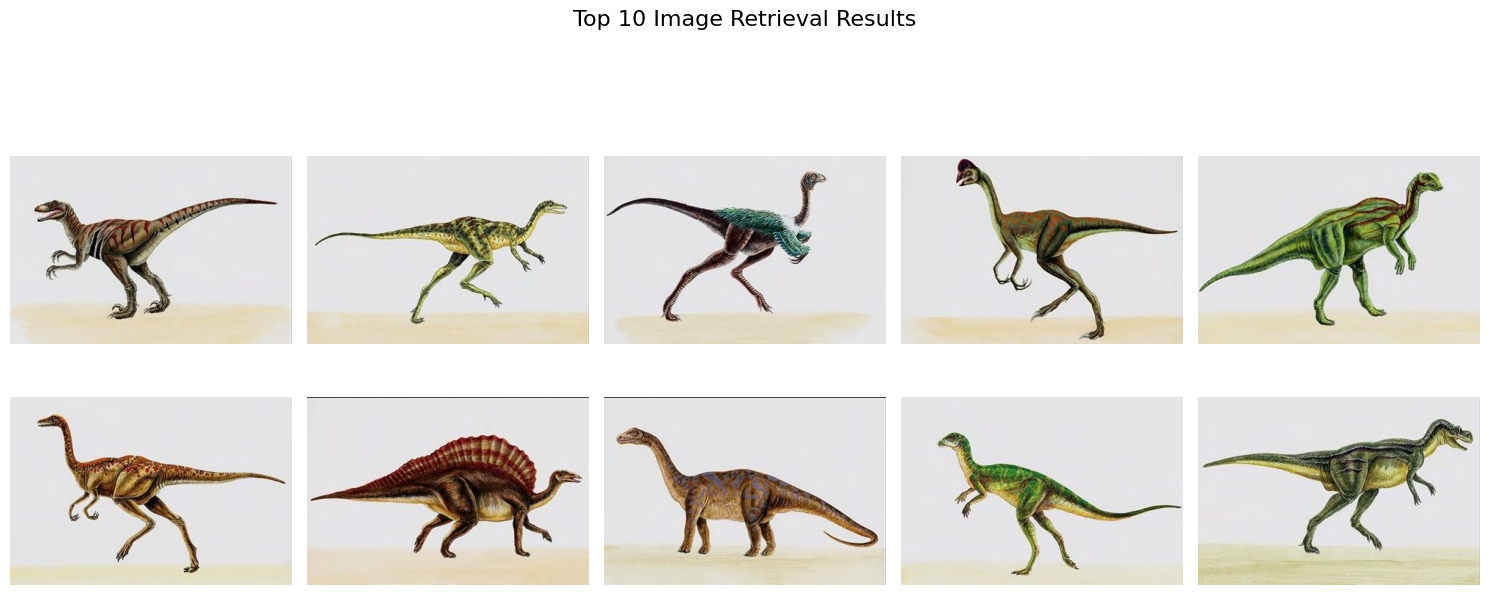

In [33]:

QUERY_IMAGE_PATH = "/content/drive/MyDrive/MIR/Corel-1K/dinosaurs/400.jpg"


if QUERY_IMAGE_PATH:
    print(f"Retrieving similar images for: {QUERY_IMAGE_PATH}")

    results = retrieve_similar(
        query_img_path=QUERY_IMAGE_PATH,
        features_db=features_db,
        image_paths=image_paths,
        top_n=TOP_N,
        scaler=scaler
    )

    print(f"Found {len(results)} images.")

    plot_results(QUERY_IMAGE_PATH, results)

else:
    print(f"Error: Query image path not found: {QUERY_IMAGE_PATH}")
    print("Please update QUERY_IMAGE_PATH in the cell above.")

In [24]:
import numpy as np
from collections import defaultdict
import os

def evaluate_model_percentage(features_db, image_paths, scaler, top_n=10):
    """
    Calculates average Precision and Recall as PERCENTAGES (0-100%) for each class.
    """
    print(f"--- Starting Evaluation (Top-{top_n}) - Scores out of 100% ---")

    # 1. Parse labels from paths
    ground_truth_labels = np.array([os.path.basename(os.path.dirname(p)) for p in image_paths])
    unique_classes = sorted(list(set(ground_truth_labels)))

    # Pre-calculate total count for each class for Recall calculation
    class_total_counts = {cls: np.sum(ground_truth_labels == cls) for cls in unique_classes}

    # Data structures to store metrics
    class_metrics = defaultdict(lambda: {'precision': [], 'recall': []})

    # 2. Prepare features (Scale if necessary)
    if scaler:
        # Avoid re-fitting, just transform
        X_db = scaler.transform(features_db)
    else:
        X_db = features_db

    # 3. Iterate through every image
    n_samples = len(image_paths)

    for i in range(n_samples):
        query_feat = X_db[i]
        true_label = ground_truth_labels[i]

        # Vectorized distance calculation
        dists = np.sum((X_db - query_feat) ** 2, axis=1)

        # Sort distances
        sorted_indices = np.argsort(dists)

        # Get Top N results
        top_indices = sorted_indices[:top_n]

        # Get labels of retrieved images
        retrieved_labels = ground_truth_labels[top_indices]

        # Calculate Hits
        relevant_retrieved = np.sum(retrieved_labels == true_label)

        # --- MODIFICATION: MULTIPLY BY 100 FOR PERCENTAGE ---

        # Precision = (Relevant / Total Retrieved) * 100
        precision_pct = (relevant_retrieved / top_n) * 100

        # Recall = (Relevant / Total Existing) * 100
        recall_pct = (relevant_retrieved / class_total_counts[true_label]) * 100

        class_metrics[true_label]['precision'].append(precision_pct)
        class_metrics[true_label]['recall'].append(recall_pct)

    # 4. Print Report
    print("\n" + "="*60)
    print(f"{'Class Type':<20} | {'Precision (%)':<15} | {'Recall (%)':<15}")
    print("-" * 60)

    avg_precisions = []
    avg_recalls = []

    for cls in unique_classes:
        p = np.mean(class_metrics[cls]['precision'])
        r = np.mean(class_metrics[cls]['recall'])
        avg_precisions.append(p)
        avg_recalls.append(r)
        # Formatting as floating point with 2 decimals
        print(f"{cls:<20} | {p:.2f}%           | {r:.2f}%")

    print("-" * 60)
    print(f"{'AVERAGE':<20} | {np.mean(avg_precisions):.2f}%           | {np.mean(avg_recalls):.2f}%")
    print("="*60)

# Run the evaluation
if 'features_db' in locals() and 'image_paths' in locals():
    evaluate_model_percentage(features_db, image_paths, scaler, top_n=TOP_N)
else:
    print("Error: features_db or image_paths not found.")

--- Starting Evaluation (Top-30) - Scores out of 100% ---

Class Type           | Precision (%)   | Recall (%)     
------------------------------------------------------------
beaches              | 19.27%           | 5.78%
bluebell             | 22.79%           | 8.55%
buildings            | 30.27%           | 9.08%
buses                | 46.57%           | 13.97%
buttercup            | 10.83%           | 4.06%
cowslip              | 16.29%           | 6.11%
crocus               | 21.50%           | 8.06%
daffodil             | 12.79%           | 4.80%
daisy                | 24.67%           | 8.71%
dandelion            | 40.52%           | 7.60%
dinosaurs            | 98.70%           | 29.61%
elephants            | 38.40%           | 11.52%
flowers              | 48.73%           | 14.62%
food                 | 62.37%           | 18.71%
fritillary           | 25.67%           | 9.62%
horses               | 50.17%           | 15.05%
iris                 | 16.50%           | 6.19%
m